In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_parquet('train-00000-of-00001-daf190ce720b3dbb.parquet', engine='pyarrow')
test = pd.read_parquet('test-00000-of-00001-fa9b3e8ade89a333.parquet', engine='pyarrow')
df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam
...,...,...
10895,Is it good and usable?\n\n[https://www.uscompa...,not_spam
10896,I'm not sure if this is the absolute best sub ...,not_spam
10897,Would love if anyone knew of any really good d...,not_spam
10898,"Fields = Hashrate, VRAM, TDP, MSRP, Profit/day",not_spam


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10900 non-null  object
 1   label   10900 non-null  object
dtypes: object(2)
memory usage: 170.4+ KB


,text,label
count,10900,10900
unique,10662,2
top,"Show off, complain, and generally have a chat ...",spam
freq,14,5500


In [5]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10662 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10662 non-null  object
 1   label   10662 non-null  object
dtypes: object(2)
memory usage: 249.9+ KB


In [6]:
df['label'].value_counts()

label
spam        5500
not_spam    5162
Name: count, dtype: int64

# EDA

In [1]:
from wordcloud import WordCloud
from collections import Counter
import nltk
import string

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eatlunches/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df_eda = df
df_eda['label'] = df['label'].astype(str).str.lower().map({'not_spam': 0, 'spam': 1})
df_eda = df_eda.dropna(subset=['text', 'label'])

df_eda['message_length'] = df_eda['text'].apply(lambda x: len(str(x)))

/tmp/ipykernel_34929/1615878895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['label'] = df['label'].astype(str).str.lower().map({'not_spam': 0, 'spam': 1})


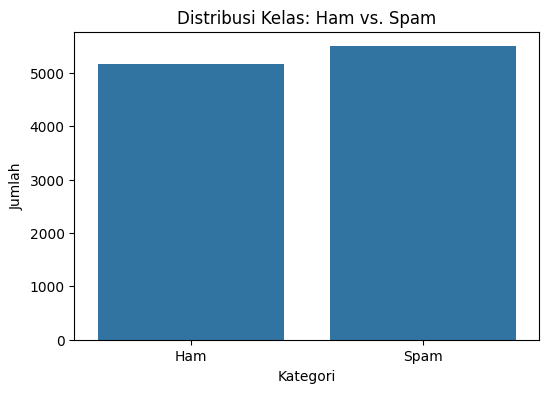

In [8]:
# Analyze class distribution (spam vs. ham).
if not df_eda.empty:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='label')
    plt.xticks([0, 1], ['Ham', 'Spam'])
    plt.title('Distribusi Kelas: Ham vs. Spam')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah')
    plt.show()
else:
    print("Data kosong, tidak bisa menampilkan distribusi kelas.")

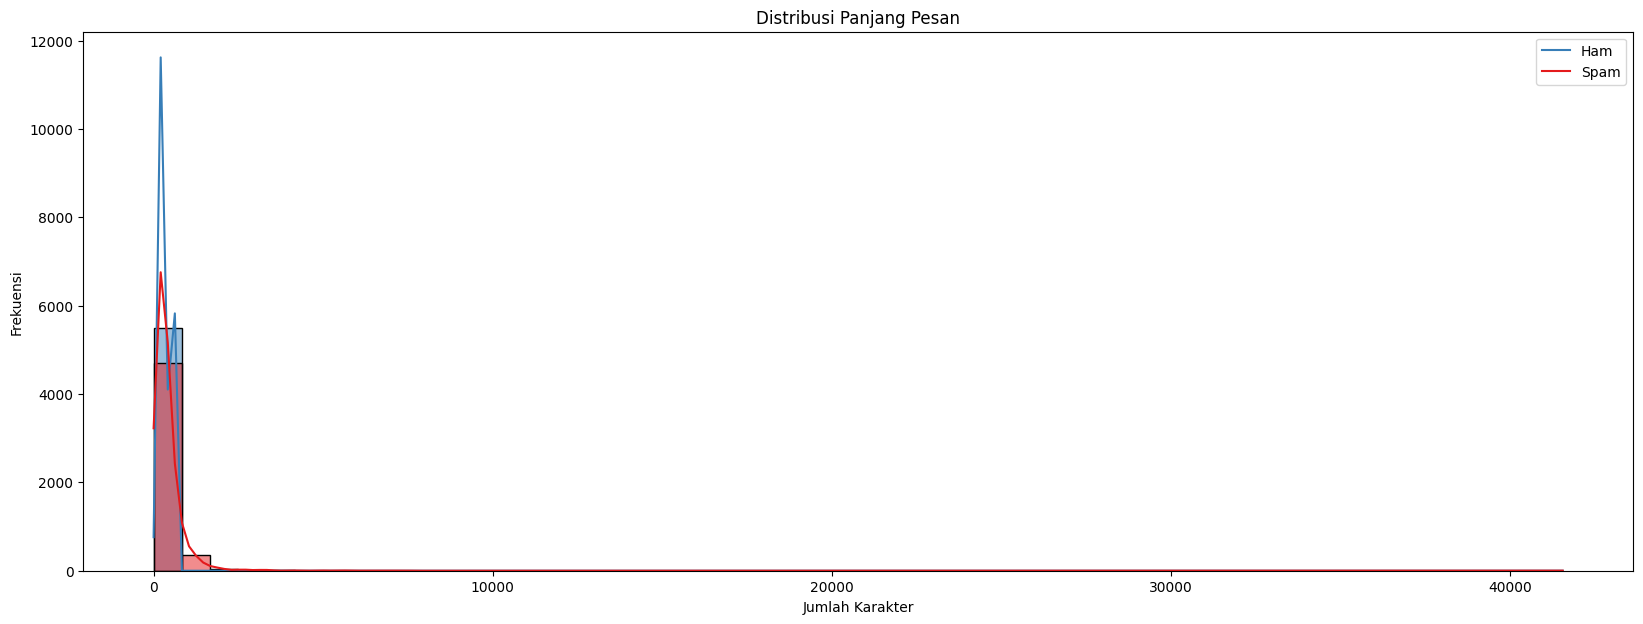

In [9]:
# Message length
if not df_eda.empty and df_eda['message_length'].notnull().sum() > 0:
    plt.figure(figsize=(20, 7))
    if df_eda['message_length'].nunique() > 1:
        sns.histplot(data=df_eda, x='message_length', hue='label', bins=50, kde=True, palette='Set1')
    else:
        sns.histplot(data=df_eda, x='message_length', hue='label', bins=50, kde=False, palette='Set1')
    plt.title('Distribusi Panjang Pesan')
    plt.xlabel('Jumlah Karakter')
    plt.ylabel('Frekuensi')
    plt.legend(labels=['Ham', 'Spam'])
    plt.show()
else:
    print("Data tidak cukup untuk histogram panjang pesan.")

/tmp/ipykernel_34929/1913200577.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


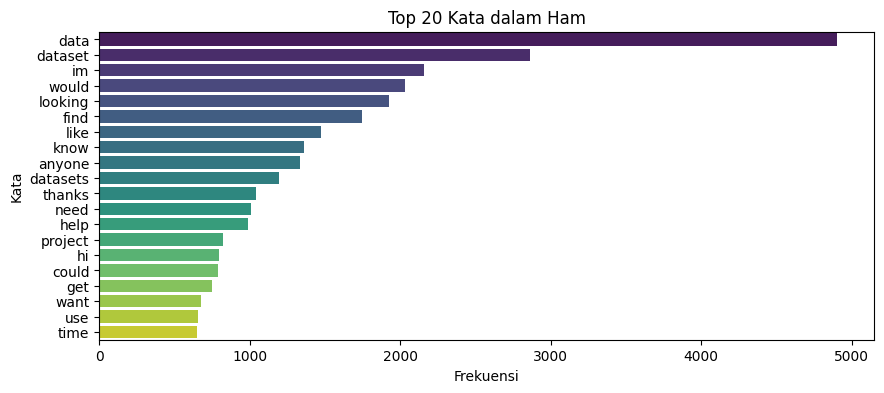

/tmp/ipykernel_34929/1913200577.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


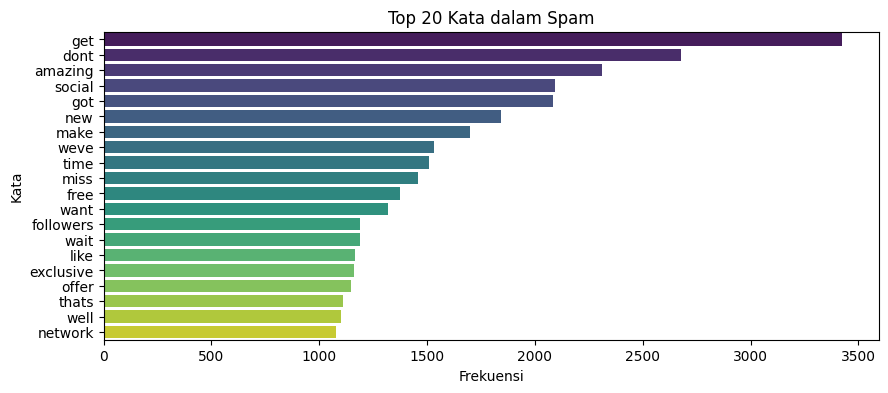

In [10]:
# Most frequent words (spam vs. ham)
def get_top_words(messages, n=20):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(messages).lower()
    words = words.translate(str.maketrans('', '', string.punctuation))
    tokens = words.split()
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return Counter(tokens).most_common(n)

top_ham_words = get_top_words(df_eda[df_eda['label'] == 0]['text']) if not df_eda[df_eda['label'] == 0].empty else []
top_spam_words = get_top_words(df_eda[df_eda['label'] == 1]['text']) if not df_eda[df_eda['label'] == 1].empty else []

def plot_top_words(word_freq, title):
    if not word_freq:
        print(f"Tidak ada kata yang bisa ditampilkan untuk: {title}")
        return
    words, freqs = zip(*word_freq)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(freqs), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.show()

plot_top_words(top_ham_words, 'Top 20 Kata dalam Ham')
plot_top_words(top_spam_words, 'Top 20 Kata dalam Spam')

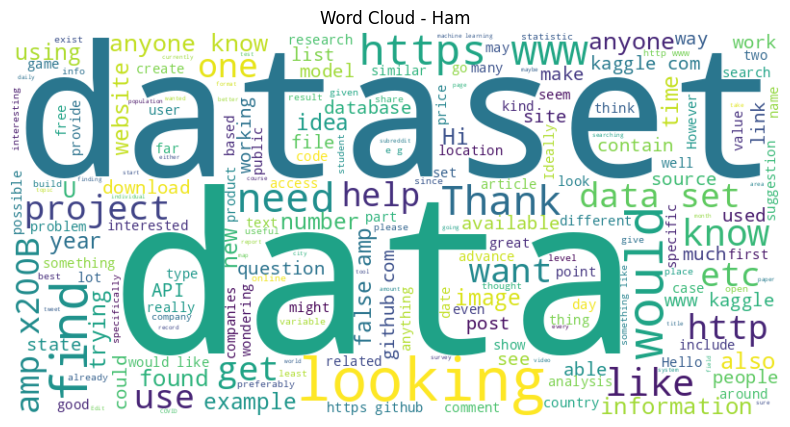

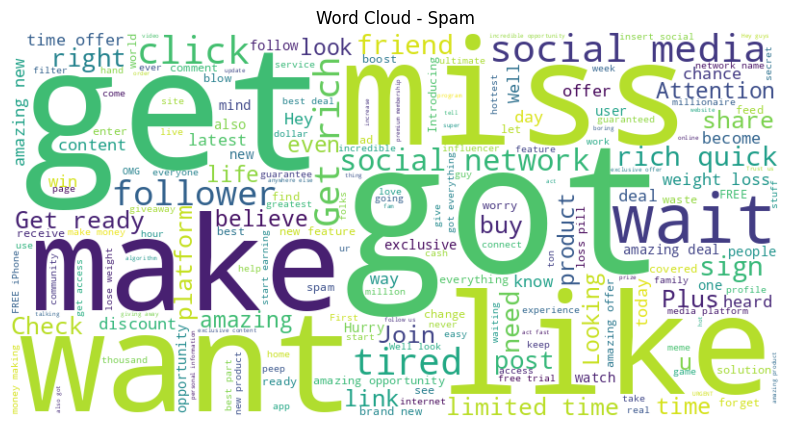

In [11]:
# Word clouds
def generate_wordcloud(messages, title):
    text = ' '.join(messages)
    if not text.strip():
        print(f"Tidak ada teks untuk Word Cloud: {title}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stopwords.words('english')).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

if not df_eda[df_eda['label'] == 0].empty:
    generate_wordcloud(df_eda[df_eda['label'] == 0]['text'], 'Word Cloud - Ham')
else:
    print("Tidak ada data untuk Word Cloud Ham.")

if not df_eda[df_eda['label'] == 1].empty:
    generate_wordcloud(df_eda[df_eda['label'] == 1]['text'], 'Word Cloud - Spam')
else:
    print("Tidak ada data untuk Word Cloud Spam.")

# Insight yang didapatkan dari EDA
**Distribusi Label**:

  * Dataset relatif seimbang antara pesan *spam* dan *not_spam*, cocok untuk tugas klasifikasi binary berbasis supervised learning.
  * Keseimbangan ini membantu meminimalkan bias akibat dominasi satu kelas.

**Panjang Pesan**:

  * Sebagian besar pesan (baik spam maupun not_spam) memiliki panjang karakter di bawah 500.
  * Pesan *spam* cenderung lebih panjang dengan beberapa outlier yang mencapai puluhan ribu karakter.
  * Pesan *not_spam* umumnya lebih ringkas, mencerminkan gaya komunikasi langsung ke tujuan.

**Analisis Frekuensi Kata (Not\_Spam)**:

  * Kata-kata yang paling sering muncul:

    * data
    * dataset
    * looking
    * project
  * Mengindikasikan bahwa banyak pesan non-spam berkaitan dengan penelusuran informasi, permintaan bantuan, atau kolaborasi profesional.

**Analisis Frekuensi Kata (Spam)**:

  * Kata-kata dominan dalam pesan spam:

    * get
    * amazing
    * followers
    * offer
    * Clickbait dan kosakata persuasif lainnya.
  * Menggambarkan sifat promosi, ajakan, dan urgensi pada pesan spam.

**Visualisasi Word Cloud**:

  * Word Cloud *not_spam* menampilkan istilah teknis dan sopan (misalnya: “data”, “help”, “project”).
  * Word Cloud *spam* menonjolkan kata-kata mendesak, sensasional, dan bersifat marketing (misalnya: “amazing”, “get”, “followers”).

**Kesimpulan**:

Perbedaan pola kata dan panjang teks antara spam dan not_spam dapat menjadi fitur penting saat merancang model deteksi spam yang efektif.

# Feature Engineering

In [10]:
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [11]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X = df['text'].apply(clean_text)

le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['label']
)

In [12]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [14]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9962494139709329
F1 Score:  0.9963536918869644
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   7 1093]]


In [15]:
svc = LinearSVC()
svc.fit(X_train_vec, y_train)

# Predict
y_pred = svc.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9976558837318331
F1 Score:  0.9977241693218024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   4 1096]]


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression()
)

stacking_model.fit(X_train_vec, y_train)

# Predict
y_pred = stacking_model.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9967182372245663
F1 Score:  0.9968109339407745
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   6 1094]]


# Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
scores = cross_val_score(LogisticRegression(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: %f" % (scores.mean()))

Random Forest CV Accuracy: 0.996131


In [19]:
scores = cross_val_score(LinearSVC(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Linear SVC CV Accuracy: %f" % (scores.mean()))

Linear SVC CV Accuracy: 0.996835


In [20]:
scores = cross_val_score(StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression()
), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Stacking Model Accuracy: %f" % (scores.mean()))

Stacking Model Accuracy: 0.996248


# Tuning

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'penalty': ['l1', 'l2'],                # Regularization type
    'solver': ['liblinear', 'saga']         # Solvers that support l1/l2
}

lr = LogisticRegression(max_iter=10000, random_state=42)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9971862634208056


In [23]:
y_pred_rf = grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9976558837318331
F1 Score:  0.9977241693218024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   4 1096]]


In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' only with 'liblinear' dual=False
    'dual': [False, True]
}

svc = LinearSVC()
svc_grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
svc_grid.fit(X_train_vec, y_train)

print("Best Parameters:", svc_grid.best_params_)
print("Best Score:", svc_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 1, 'dual': False, 'penalty': 'l2'}
Best Score: 0.9968345635380389


/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Li

In [25]:
y_pred_rf = svc_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9976558837318331
F1 Score:  0.9977241693218024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   4 1096]]


In [26]:
param_grid = {
    'lr__C': [0.1, 1.0, 10],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'final_estimator__C': [0.1, 1.0, 10]
}

base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier())
]

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=False 
)

stack_grid = GridSearchCV(estimator=stacking_model, param_grid=param_grid, 
                    cv=5, scoring='f1', verbose=1, n_jobs=-1)

stack_grid.fit(X_train_vec, y_train)

print("Best Parameters:", stack_grid.best_params_)
print("Best Score:", stack_grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'final_estimator__C': 10, 'lr__C': 10, 'rf__max_depth': None, 'rf__n_estimators': 200}
Best Score: 0.997386683788765


In [27]:
y_pred_rf = stack_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9967182372245663
F1 Score:  0.9968109339407745
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   6 1094]]


# Save

In [28]:
import joblib

joblib.dump(grid, 'logistic_regression_model.pkl')
joblib.dump(svc_grid, 'svc_model.pkl')
joblib.dump(stack_grid, 'stacking_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [29]:
# Load models
lr_loaded = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example usage
text = """Dear Sir,

Please be aware of appointment on 05/13/2025."""
X_new = vectorizer.transform([text])
prediction = lr_loaded.predict(X_new)
print(prediction)

[0]


Exception ignored in: <function ResourceTracker.__del__ at 0x7f9a37041300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f5a44845300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe59384d300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip